In [2]:
#Cargando librerías 

from IPython.display import clear_output
import importlib

from PIL import Image
import matplotlib.pyplot as plt
import scipy as sp


import numpy as np
import pandas as pd
import os
import sys  

root = os.getcwd() + "/.."

sys.path.insert(0, root)

import src.positioning_sensors as ps
importlib.reload(ps)

import src.regionGrowing as rg
importlib.reload(rg)

import src.manageExperiments as me
importlib.reload(me)

import config.config as cfg
importlib.reload(cfg)


from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage.filters import rank

from skimage.draw import line

In [3]:
fn = "linz_with_init_net_exp_2.txt"
setup = me.readConfigFile(fn)
for key in iter(setup):
    print(str(key)+":" ,setup[str(key)])

experiment_id: linz_experiment_with_initial_positions_no2/
folder_input: locations/linz/
folder_semivariances: semivariances/
folder_output: results/
input_ntli: world_atlas_linzn
input_evm: linz_prioridades
output_semivariances: semivariance050512022
output_values: optimum_values.csv
output_args: optimum_arguments.csv
desaturation_th: -1
neglect_values: -1
tolerance_distance: 0.5
tolerance_angle: 15
filterg_sx: 0.5
filterg_sy: 0.5
gaussian_mode: constant
init_fixed_net: [[39, 22], [35, 29], [34, 31], [34, 34], [36, 39]]
nsensors: [0, 1, 2, 3, 4, 5]
sensitivity_c: [1, 10, 20, 30, 40]
flatness_means_decrease: True
ga_params: {'max_num_iteration': 100, 'population_size': 2000, 'mutation_probability': 0.1, 'elit_ratio': 0.1, 'crossover_probability': 0.5, 'parents_portion': 0.3, 'crossover_type': 'uniform', 'max_iteration_without_improv': 500}


In [8]:
#this variable tells how to interpret a flat semivariance value, do we cut before of after the flat semivariance region 
flat_means_decrease = bool(setup['flatness_means_decrease'])
print(flat_means_decrease)

True


In [9]:
#cargamos imagenes en luminance e importance

img1 = cfg.data + setup["folder_input"] + setup["input_ntli"]
img2 = cfg.data + setup["folder_input"] + setup["input_evm"]

NTLI = np.array(Image.open(img1))
EVM = np.array(Image.open(img2))

In [10]:
NTLI = ps.readIMG(img1)

#EAM: Environtmental attention map is the importance
EAM = ps.readIMG(img2, invert = True)


EAM = EAM/np.max(EAM)

# if saturation threshold is -1, then we do not apply desaturation
th = int(setup["desaturation_th"])

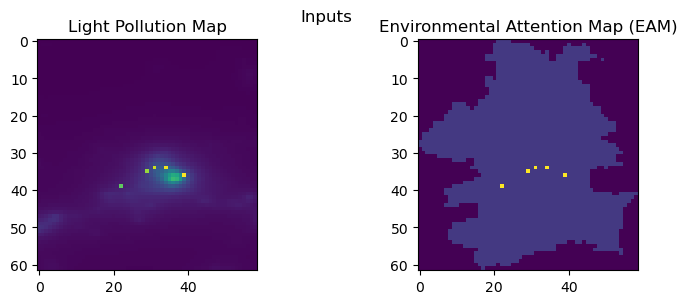

In [11]:
S = np.zeros(NTLI.shape)

for c in setup["init_fixed_net"]: 
    S[tuple(c)] = 5

plt.figure(figsize=(9, 3))
plt.subplot(121)
plt.imshow(NTLI+S)
plt.title("Light Pollution Map")
plt.subplot(122)
plt.imshow(EAM+S)
plt.title("Environmental Attention Map (EAM)")
plt.suptitle('Inputs')
plt.show()

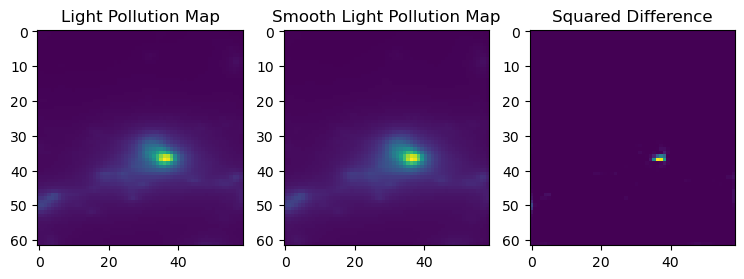

In [12]:
#loading smoothing parameters
sigma_y = setup['filterg_sy']
sigma_x =setup['filterg_sx']
sigma = [sigma_y, sigma_x]

FDNTLI = sp.ndimage.gaussian_filter(NTLI, sigma, mode = setup['gaussian_mode'])
nonsatc = np.copy(FDNTLI)


plt.figure(figsize=(9, 3))
plt.subplot(131)
plt.imshow(NTLI)
plt.title("Light Pollution Map")
plt.subplot(132)
plt.imshow(FDNTLI)
plt.title("Smooth Light Pollution Map")
plt.subplot(133)
plt.imshow((NTLI-FDNTLI)**2)
plt.title("Squared Difference")

plt.show()

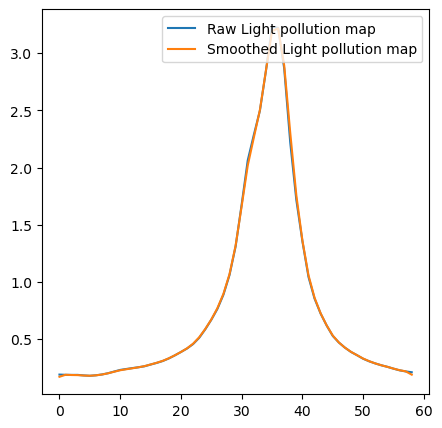

In [13]:
plt.figure(figsize=(5, 5))
plt.subplot(111)
plt.plot(NTLI[35,:], label = "Raw Light pollution map")
plt.plot(FDNTLI[35,:], label = "Smoothed Light pollution map")
plt.legend()
plt.show()

In [14]:
#fill the required params
#si = (28,19)
coords = ps.get_coords(EAM==1)
params = {"type": "semivar", 
          "atol": setup["tolerance_angle"], 
          "dtol": setup["tolerance_distance"]}


sv = np.zeros(FDNTLI.shape)

#tell to the class, which object is going to be used to make the semivariogram

rG = rg.rGrowing(FDNTLI)

rG.setParams(params)

n = len(coords)

#ncords x imagesize m x n
image_size = (n, FDNTLI.shape[0]*FDNTLI.shape[1])
allsemivariances = np.zeros(image_size)
allmask = np.zeros(image_size)


df = pd.DataFrame()

In [29]:
#BoundingBox(left=14.02492239, bottom=48.07084832444445, right=14.51658886, top=48.587514784444444)

from matplotlib_scalebar.scalebar import ScaleBar
#x1,y1 333747.2405000000144355,2249895.8226999999023974 : 382747.2405000000144355,2309895.8226999999023974
coordinates_x = [14.02492239, 14.51658886]
coordinates_y = [48.587514784444444, 48.07084832444445]

coordinates_x = [14.024922, 14.516588]
coordinates_y = [48.587514, 48.070848]

sx = (coordinates_x[1]-coordinates_x[0])/FDNTLI.shape[1]
sy = (coordinates_y[0]-coordinates_y[1])/FDNTLI.shape[0]


long_coordinates = np.round(np.arange(coordinates_x[0], coordinates_x[1]+1, sx),4)
lat_coordinates = np.round(np.arange(coordinates_y[1], coordinates_y[0]+1, sy),4)



print("longitude cell size in epsg coordinates:",(long_coordinates[1]-long_coordinates[0]))
print("latitude cell size in epsg coordinates:",(lat_coordinates[1]-lat_coordinates[0]))

rounded_coordinates_x = np.round(100*(np.round(long_coordinates/100))).astype(int)
rounded_coordinates_y = np.round(1000*(np.round(lat_coordinates/1000))).astype(int)


rounded_coordinates_x = long_coordinates
rounded_coordinates_y = lat_coordinates

dpi_res = 300

MAP = EAM*NTLI
MAP[MAP==0] = np.NaN

img = MAP
fig, ax = plt.subplots(figsize = (MAP.shape[0]*0.1,MAP.shape[1]*0.1))



im = ax.imshow(img)


X_coords = rounded_coordinates_x
Y_coords = rounded_coordinates_y

ax.set_xticks([0, NTLI.shape[1]-1],[X_coords[0],X_coords[-1]])
ax.set_yticks([0, NTLI.shape[0]-1],[Y_coords[-1],Y_coords[0]])
ax.add_artist(ScaleBar(617.8991644,location='lower left'))


#divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="5%", pad=0.05)

cax = plt.axes((0.87, 0.0, 0.11, 0.9))
plt.colorbar(im, ticks=[np.min(img), np.max(img)])

plt.grid(False)
plt.imshow(MAP)
#plt.colorbar()
plt.show()

#fig.savefig('../figures/fig02roi.png', format='png', dpi=dpi_res,bbox_inches="tight")

longitude cell size in epsg coordinates: 0.008399999999999963
latitude cell size in epsg coordinates: 0.00840000000000174


ValueError: cannot convert float NaN to integer

<Figure size 620x590 with 3 Axes>

[39, 22]


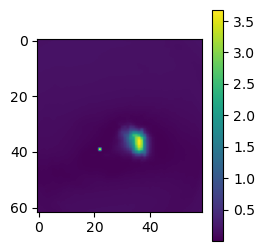

/var/folders/k9/wpfgnz550_n_k3t9tg8scnlw0000gn/T/ipykernel_96333/578978988.py:17: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(132)


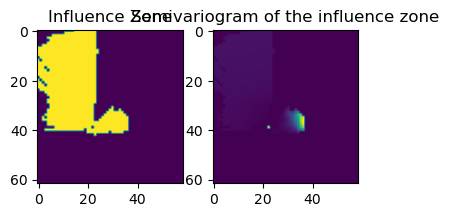

In [17]:
for si in setup["init_fixed_net"][:1]:
    print(si)
    
    sv = rG.makeSemivarianceMap(tuple(si))
    sm = ps.constructMask(si, sv, flat_means_decrease)
    
    plt.figure(figsize = (9, 3))
    plt.subplot(131)
    ax.set_xticks([0, NTLI.shape[1]-1], [X_coords[0],X_coords[-1]])
    ax.set_yticks([0, NTLI.shape[0]-1], [Y_coords[-1],Y_coords[0]])
    ax.add_artist(ScaleBar(617.8991644,location='lower left'))
    sv[tuple(si)] = np.max(sv)
    plt.imshow(sv)
    plt.colorbar()
    plt.show()
    plt.title("Semivariogram"+" "+str(si))
    plt.subplot(132)
    sm[tuple(si)] = np.min(sm)
    plt.imshow(sm)
    plt.title("Influence Zone")
    plt.subplot(133)
    smsv = sm*sv
    smsv[tuple(si)] = np.max(smsv)
    plt.imshow(smsv)
    plt.title("Semivariogram of the influence zone")
    plt.show()

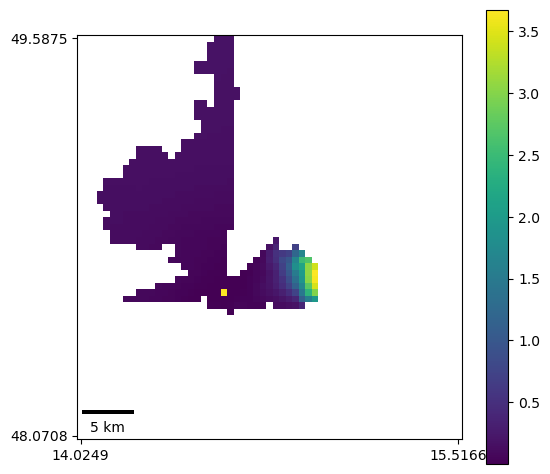

In [22]:
fig, ax = plt.subplots(figsize = (MAP.shape[0]*0.1,MAP.shape[1]*0.1))

si  = setup["init_fixed_net"][:1]

si = tuple(si[0])

sv = rG.makeSemivarianceMap(si)

sm = ps.constructMask(si, sv, flat_means_decrease)

ax.set_xticks([0, NTLI.shape[1]-1], [X_coords[0],X_coords[-1]])
ax.set_yticks([0, NTLI.shape[0]-1], [Y_coords[-1],Y_coords[0]])

ax.add_artist(ScaleBar(617.8991644,location='lower left'))

sv[tuple(si)] = np.max(sv)

svEAM = sv*EAM

smsv[smsv*EAM==0]= np.NaN
smsv[smsv*EAM==2]= np.NaN



plt.imshow(smsv)
plt.colorbar()


fig.savefig('../figures/semivarianceMap.png', format='png', dpi=dpi_res,bbox_inches="tight")

In [24]:
def deg_to_dms(deg, pretty_print=None, ndp=4):
    """Convert from decimal degrees to degrees, minutes, seconds."""

    m, s = divmod(abs(deg)*3600, 60)
    d, m = divmod(m, 60)
    if deg < 0:
        d = -d
    d, m = int(d), int(m)

    if pretty_print:
        if pretty_print=='latitude':
            hemi = 'N' if d>=0 else 'S'
        elif pretty_print=='longitude':
            hemi = 'E' if d>=0 else 'W'
        else:
            hemi = '?'
        return "{d:d}°{m:d}'{hemi:1s}".format(
                    d=abs(d), m=m, s=s, hemi=hemi, ndp=ndp)
    return d, m, s

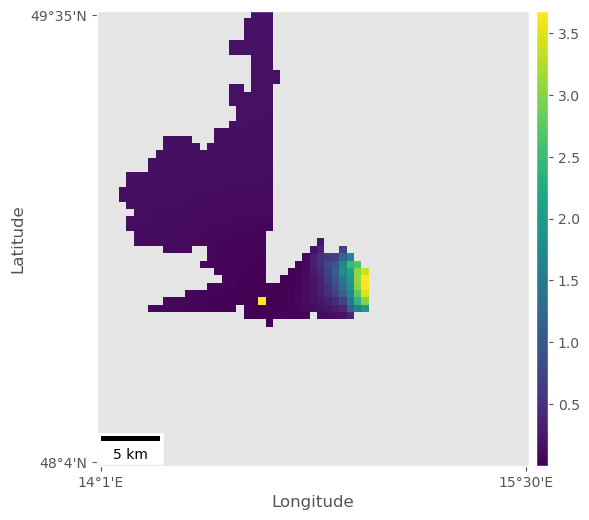

In [31]:

dpi_res = 300
plt.style.use("ggplot")
MAP = EAM*NTLI
MAP[MAP==0] = np.NAN


fig, ax = plt.subplots(figsize = (MAP.shape[0]*0.1,MAP.shape[1]*0.1))

#img = smsv

im = ax.imshow(smsv)


X_coords = rounded_coordinates_x
Y_coords = rounded_coordinates_y


ax.set_xticks([0, NTLI.shape[1]-1], [ deg_to_dms(X_coords[0], pretty_print="longitude") , deg_to_dms(X_coords[-1], pretty_print="longitude") ])
ax.set_yticks([0, NTLI.shape[0]-1], [ deg_to_dms(Y_coords[-1], pretty_print="latitude") , deg_to_dms(Y_coords[0], pretty_print="latitude") ])
ax.add_artist(ScaleBar(617.8991644,location='lower left'))


#divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="5%", pad=0.05)
#plt.colorbar(im, cax=cax,ticks=[0, np.max(img)])

ax.grid(False)
im = ax.imshow(smsv)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(im, cax=cax) # Similar to fig.colorbar(im, cax = cax)
plt.show()


fig.savefig('../figures/fig02roi.pdf', format='pdf', dpi=dpi_res,bbox_inches="tight")

##nsres=926.63896835
##ewres=617.8991644